In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv


In [2]:
!pip install shap imbalanced-learn lightgbm xgboost

## Import Libraries



In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

#Visulisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

#Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

import tensorflow as tf

from collections import Counter
import time

#Random Seed 
np.random.seed(42)
tf.random.set_seed(42)

print(f"Tensorflow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))>0}")

2026-01-26 06:02:26.687311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769407346.717909      97 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769407346.727709      97 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769407346.751345      97 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769407346.751379      97 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769407346.751383      97 computation_placer.cc:177] computation placer alr

Tensorflow Version: 2.19.0
GPU Available: False


2026-01-26 06:02:29.785465: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Data Loading

In [4]:
base_path = '/kaggle/input/network-intrusion-dataset'

#all csv files
try:
    csv_files = [f for f in os.listdir(base_path) if f.endswith('csv')]
    print(f"Found {len(csv_files)} CSV files:")
    for i, file in enumerate(csv_files,1):
        print(f" {i}.{file}")
except:
    print("The base path for the dataset is not correct.")
    csv_files = []


#load all csv files and combine load a subset first
dfs = []

if csv_files:
    for file in csv_files:
        try:
            df_temp = pd.read_csv(os.path.join(base_path, file), encoding='utf-8')
            dfs.append(df_temp)
            print(f"Loaded {file}: {df_temp.shape}")
        except Exception as e:
            print(f"Error Loading..")

    #combine all dataframes
    df = pd.concat(dfs, ignore_index = True)
    print(f"Total Dataset: {df.shape}")
    print(f"Total Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

else:
    print("Loading Samples")
    df = pd.DataFrame()


#display first few rows
if not df.empty:
    display(df.head())

Found 8 CSV files:
 1.Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 2.Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
 3.Tuesday-WorkingHours.pcap_ISCX.csv
 4.Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 5.Monday-WorkingHours.pcap_ISCX.csv
 6.Friday-WorkingHours-Morning.pcap_ISCX.csv
 7.Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 8.Wednesday-workingHours.pcap_ISCX.csv
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: (286467, 79)
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: (170366, 79)
Loaded Tuesday-WorkingHours.pcap_ISCX.csv: (445909, 79)
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: (225745, 79)
Loaded Monday-WorkingHours.pcap_ISCX.csv: (529918, 79)
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv: (191033, 79)
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: (288602, 79)
Loaded Wednesday-workingHours.pcap_ISCX.csv: (692703, 79)
Total Dataset: (2830743, 79)
Total Rows: 2,830,743 | Column

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## Dataset Exploration

In [5]:
print(f"Dataset Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")

#Column names and datatypes
print(f"Column Data Types:")
print(df.dtypes.value_counts())

#Label or  Label Column
label_col = 'Label' if 'Label' in df.columns else ' Label' if ' Label' in df.columns else None

if label_col:
    print(f"\nTarget Variable: '{label_col}'")
    print(f"\nAttack type Distribution:")
    attack_counts = df[label_col].value_counts()
    print(attack_counts)

    print(f"\n Percentage Distribution:")
    print((df[label_col].value_counts(normalize=True)*100).round(2))
else:
    print("Label Column not Found !!")


#Missing values
print("\n Missing values:")
missing = df.isnull().sum()
missing_pct = (missing/len(df))*100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values(by = 'Missing_Count', ascending=False).head(10)
print(missing_df[missing_df['Missing_Count']>0])

#Statistical Summary of first 5 numeric columns
print(f"Statistical Summary of first 5 columns:")
display(df.describe().iloc[:, :5].T)

Dataset Dimensions: 2,830,743 rows x 79 columns
Memory Usage: 1833.87 MB
Column Data Types:
int64      54
float64    24
object      1
Name: count, dtype: int64

Target Variable: ' Label'

Attack type Distribution:
 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

 Percentage Distribution:
 Label
BENIGN                        80.30
DoS Hulk                       8.16
PortScan                       5.61
DDoS                           4.52
DoS G

,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.0,2.0,2.0,5.0,219759.0
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.0,12.0,62.0,187.0,12900000.0


## EDA (Exploratory Data Analysis)

### EDA analysis of Attack Distribution

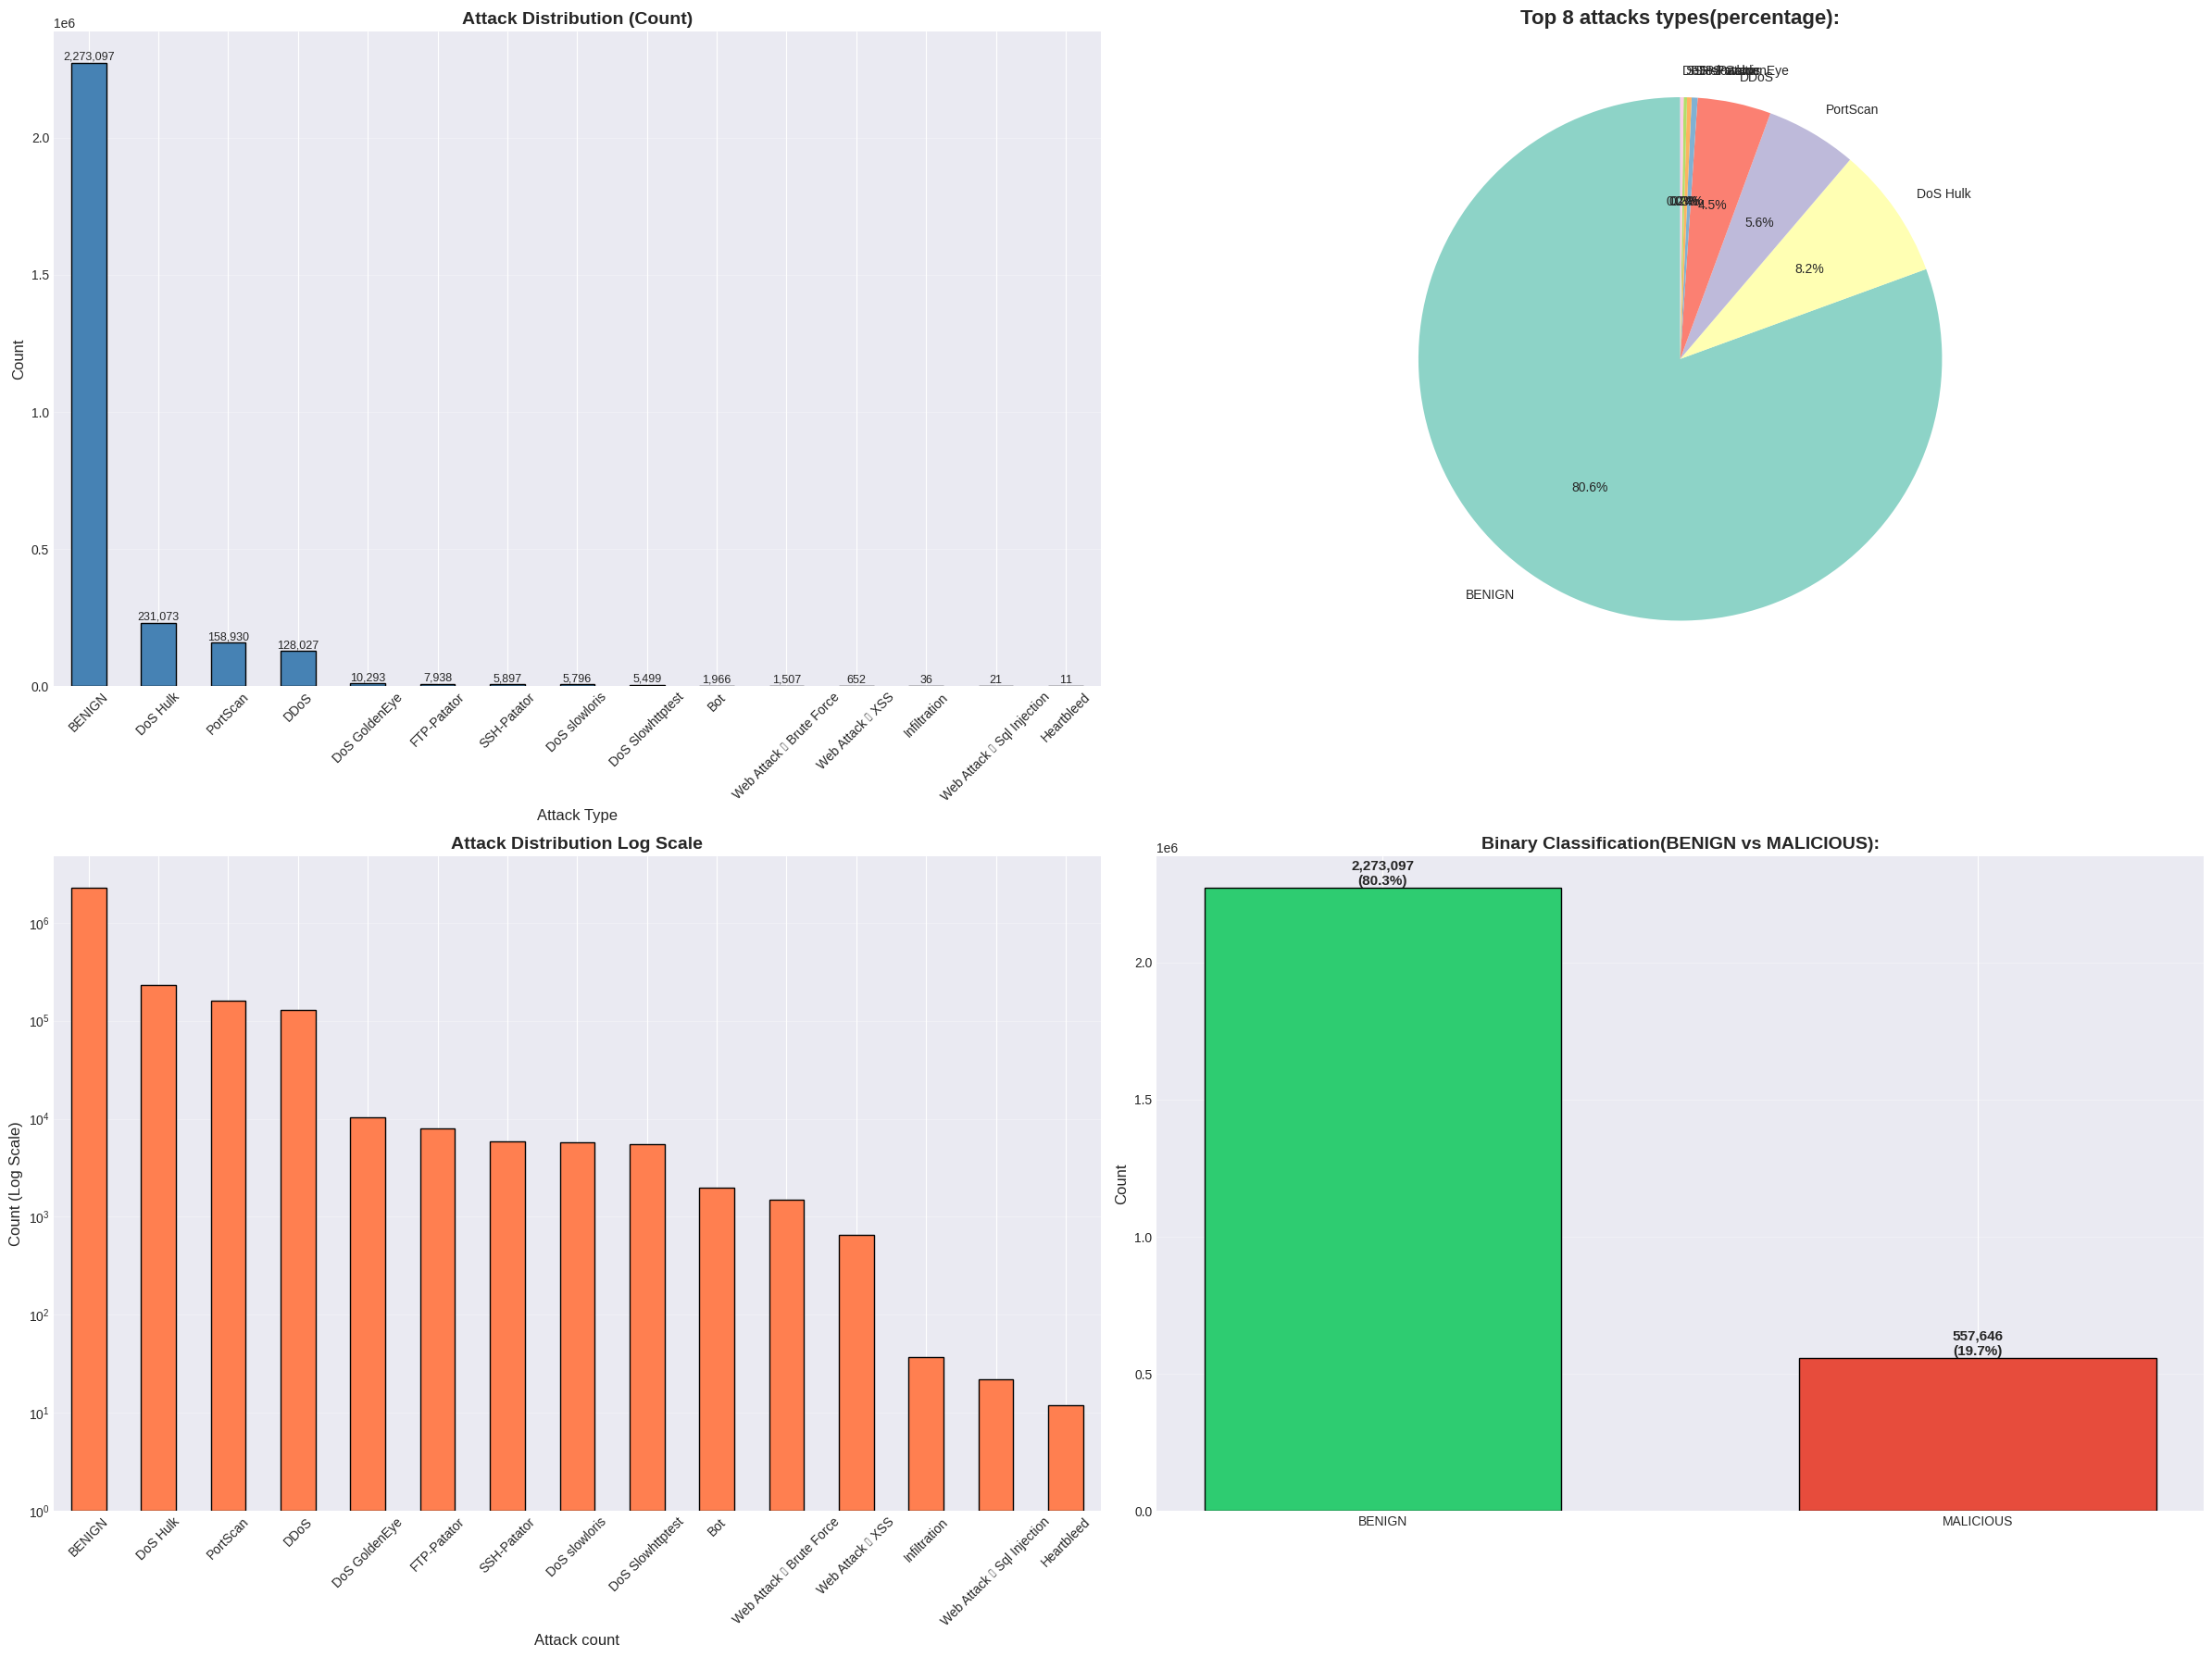

Key Statistics
Total Samples: 2,830,743
Benign Traffic: 2,273,097 (80.30%)
Malicious Traffic: 557,646 (19.70%)
Number of Attack Types: 15
Imbalance Ratio: 1:257340


In [6]:
if label_col and not df.empty:
    fig, axes = plt.subplots(2,2, figsize=(24,18))

    #Attack Type Count bar plot
    attack_counts = df[label_col].value_counts()
    ax1 = axes[0,0]
    attack_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor = 'black')
    ax1.set_title('Attack Distribution (Count)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Attack Type', fontsize =12)
    ax1.set_ylabel('Count', fontsize =12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis = 'y', alpha=0.3)

    #add count labels on bars
    for i,v in enumerate(attack_counts.values):
        ax1.text(i, v, f'{v:,}', ha ='center', va='bottom', fontsize=9)

    #Attack Type Percentage(Pie Chart- Top Attacks)
    ax2 = axes[0,1]
    top_attacks = attack_counts.head(8)
    colors = plt.cm.Set3(range(len(top_attacks)))
    ax2.pie(top_attacks.values, labels = top_attacks.index, autopct='%1.1f%%',
           startangle = 90, colors=colors)
    ax2.set_title('Top 8 attacks types(percentage):', fontsize=16, fontweight='bold')

    #Log Scale Distribution
    ax3 = axes[1,0]
    attack_counts.plot(kind='bar', ax=ax3, color='coral', edgecolor='black', log = True)
    ax3.set_title('Attack Distribution Log Scale', fontsize = 14, fontweight='bold')
    ax3.set_xlabel('Attack count', fontsize =12)
    ax3.set_ylabel('Count (Log Scale)', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)

    #Binary Classification (benign vs Malicious)
    ax4 = axes[1,1]
    binary_dist = df[label_col].apply(lambda x: 'BENIGN' if x== 'BENIGN' else 'MALICIOUS').value_counts()
    colors_binary = ['#2ecc71', '#e74c3c']
    ax4.bar(binary_dist.index, binary_dist.values, color=colors_binary, edgecolor='black', width=0.6)
    ax4.set_title('Binary Classification(BENIGN vs MALICIOUS):', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12)
    ax4.grid(axis='y', alpha=0.3)

    #Add count labels
    for i,v in enumerate(binary_dist.values):
        ax4.text(i, v, f"{v:,}\n({v/len(df)*100:.1f}%)", ha='center', va='bottom', fontsize =11, fontweight = 'bold')

    plt.tight_layout()
    plt.show()


    #Key Statistics
    print('Key Statistics')
    print(f"Total Samples: {len(df):,}")
    print(f"Benign Traffic: {(df[label_col]=='BENIGN').sum():,} ({(df[label_col]=='BENIGN').sum()/len(df)*100:.2f}%)")
    print(f"Malicious Traffic: {(df[label_col] != 'BENIGN').sum():,} ({(df[label_col] != 'BENIGN').sum()/len(df)*100:.2f}%)")
    print(f"Number of Attack Types: {df[label_col].nunique()}")
    print(f"Imbalance Ratio: 1:{len(df)//attack_counts.min()}")

### EDA Feature Analysis

Total Numeric Features:78
Features with zero variance to be removed:
Found 8 zero-variance features
 [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
creating binary target for binary classification


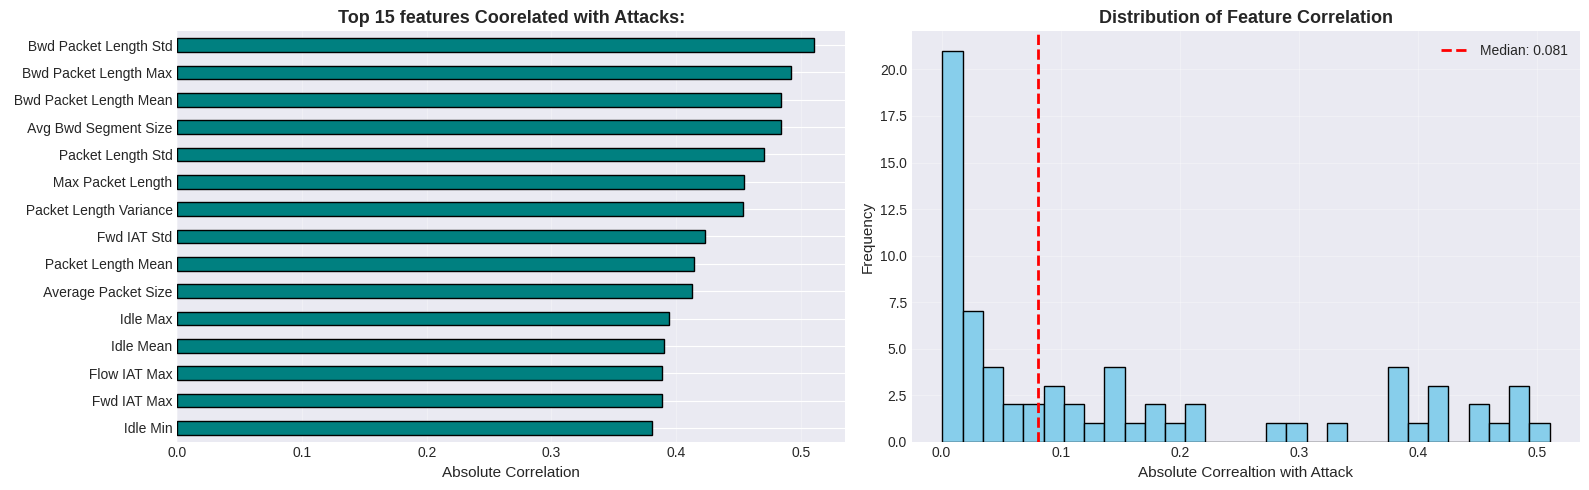


 Top 10 important features by correlation
 Bwd Packet Length Std     0.510216
Bwd Packet Length Max      0.492007
 Bwd Packet Length Mean    0.484189
 Avg Bwd Segment Size      0.484189
 Packet Length Std         0.470252
 Max Packet Length         0.454054
 Packet Length Variance    0.453847
 Fwd IAT Std               0.422755
 Packet Length Mean        0.414059
 Average Packet Size       0.413037
Name: is_attack, dtype: float64


In [7]:
if not df.empty:
    #select only numeric features only
    numeric_cols = [
        c for c in df.select_dtypes(include=[np.number]).columns
        if c != 'is_attack'
    ]
    # numeric_cols = [c for c in numeric_cols if c != 'is_attack']

    #remove infinite values
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    print(f"Total Numeric Features:{len(numeric_cols)}")

    #Feature Statistics
    print("Features with zero variance to be removed:")
    zero_var_features = df[numeric_cols].std()[df[numeric_cols].std()==0].index.tolist()
    print(f"Found {len(zero_var_features)} zero-variance features")
    if zero_var_features:
        print(f" {zero_var_features[:10]}")


    #correlation with target binary classification
    if label_col:
        print(f"creating binary target for binary classification")
        df['is_attack'] = (df[label_col] != 'BENIGN').astype(int)

        #calculate correlations
        correlations = df[numeric_cols + ['is_attack']].corr().loc[numeric_cols,'is_attack'].abs().sort_values(ascending=False)

        #plot top correlated features
        fig, axes = plt.subplots(1, 2, figsize=(16,5))

        #Top 15 correlated features
        ax1 = axes[0]
        top_corr = correlations.head(15)
        top_corr.plot(kind='barh', ax=ax1, color = 'teal', edgecolor='black')
        ax1.set_title('Top 15 features Coorelated with Attacks:', fontsize = 13, fontweight='bold')
        ax1.set_xlabel('Absolute Correlation' , fontsize=11)
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)

        ax2 = axes[1]
        ax2.hist(correlations.values, bins=30, color='skyblue', edgecolor='black')
        ax2.set_title('Distribution of Feature Correlation', fontsize=13, fontweight='bold')
        ax2.set_xlabel('Absolute Correaltion with Attack', fontsize=11)
        ax2.set_ylabel('Frequency', fontsize=11)
        ax2.axvline(correlations.median(), color='red', linestyle='--', linewidth = 2, label=f"Median: {correlations.median():.3f}")
        ax2.legend()
        ax2.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n Top 10 important features by correlation")
        print(correlations.head(10))

### Correlation Heatmap

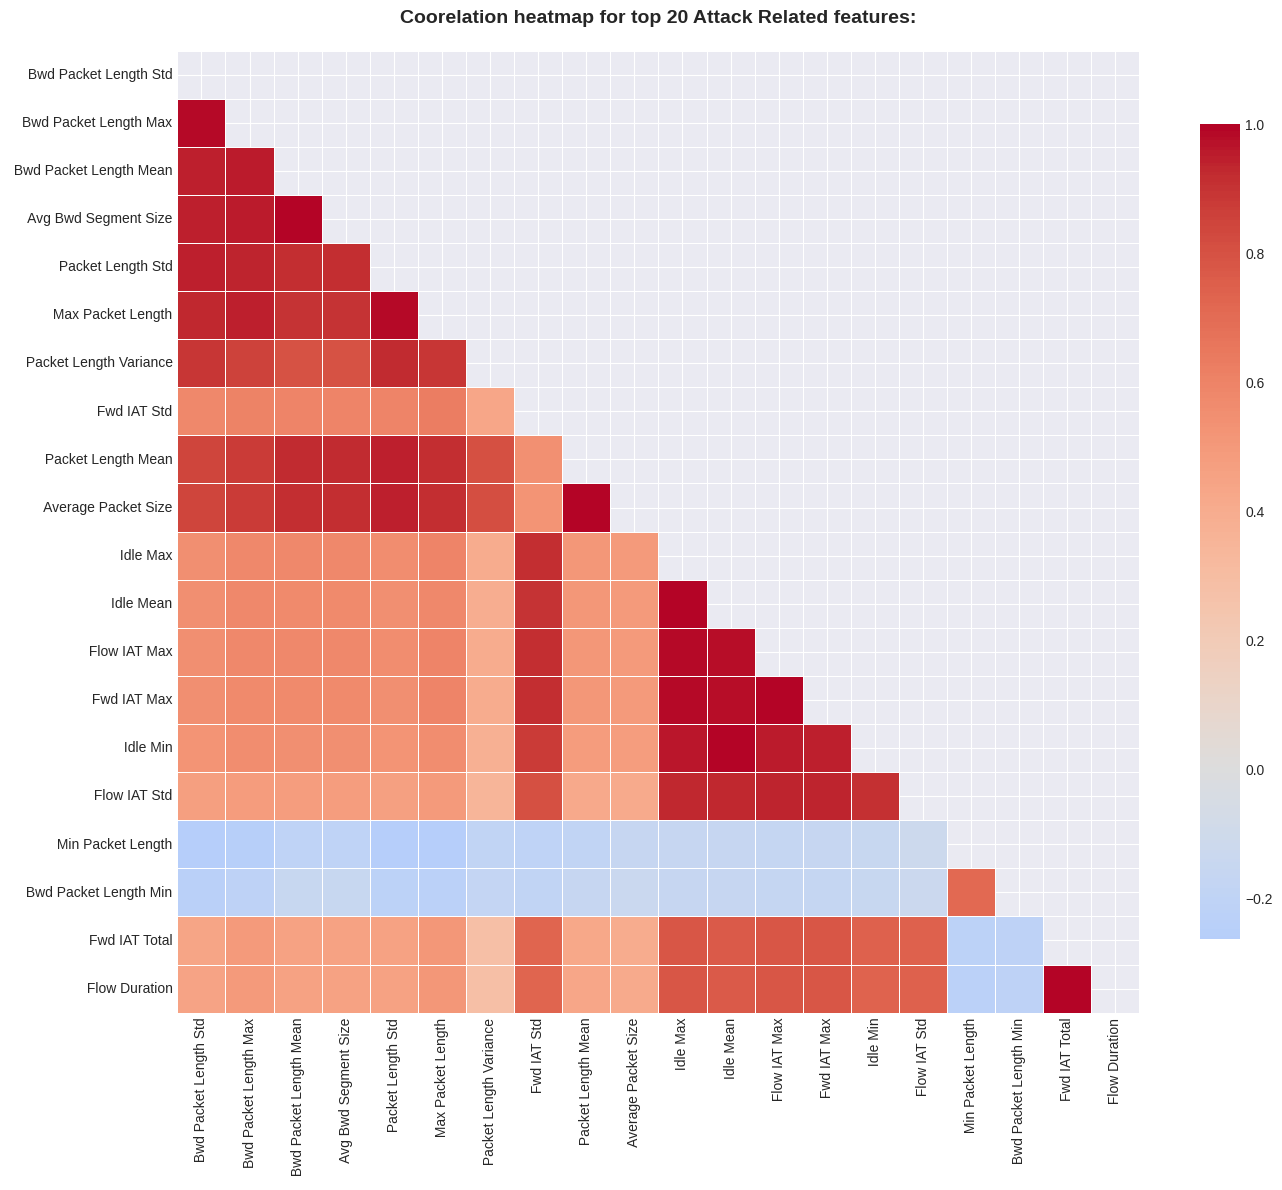

Highly Correlated Feature Pairs(>0.9)
 . Bwd Packet Length Std<->Bwd Packet Length Max: 0.983
 . Bwd Packet Length Std<-> Bwd Packet Length Mean: 0.942
 . Bwd Packet Length Std<-> Avg Bwd Segment Size: 0.942
 . Bwd Packet Length Std<-> Packet Length Std: 0.942
 . Bwd Packet Length Std<-> Max Packet Length: 0.933
 .Bwd Packet Length Max<-> Bwd Packet Length Mean: 0.959
 .Bwd Packet Length Max<-> Avg Bwd Segment Size: 0.959
 .Bwd Packet Length Max<-> Packet Length Std: 0.940
 .Bwd Packet Length Max<-> Max Packet Length: 0.948
 . Bwd Packet Length Mean<-> Avg Bwd Segment Size: 1.000


In [8]:
if not df.empty and len(numeric_cols)>0:
    if label_col and 'is_attack' in df.columns:
        top_features = correlations.head(20).index.tolist()

        corr_matrix = df[top_features].corr()

        #plot heatmap
        plt.figure(figsize=(14,12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #mask upper triangle
        sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
                   center=0, square=True, linewidths=0.5, cbar_kws={"shrink":0.8})
        plt.title('Coorelation heatmap for top 20 Attack Related features:',
                 fontsize=14, fontweight='bold',pad=20)
        plt.tight_layout()
        plt.show()

        #highly correlated feature pairs potential multicollinearity
        print("Highly Correlated Feature Pairs(>0.9)")
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i,j])>0.9:
                    high_corr_pairs.append((corr_matrix.columns[i],
                                           corr_matrix.columns[j],
                                           corr_matrix.iloc[i,j]))

        if high_corr_pairs:
            for feat1, feat2, corr_val in high_corr_pairs[:10]:
                print(f" .{feat1}<->{feat2}: {corr_val:.3f}")
        else:
            print(f" No highly correlated featured pairs found good for model.")

## Data Preprocessing 

### Data Cleaning

In [9]:
df_clean = df.copy()

#clean column names remove trailing/leading spaces
df_clean.columns = df_clean.columns.str.strip()
label_col = 'Label' if 'Label' in df_clean.columns else label_col

#handling infinite values replaced with nan
#btw already remove in previous cell
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Preprocessing {numeric_cols} numeric columns..")

inf_count = np.isinf(df_clean[numeric_cols]).sum().sum()
print(f" Found {inf_count:,} infinite values")

if inf_count>0:
    df_clean[numeric_cols] = df_clean[numeric_cols].replace([np.inf, -np.inf], np.nan)


#handling missing values with median of numeric columns
missing_before = df_clean.isnull().sum().sum()
print(f" Before Missing Values: {missing_before:,}")

if missing_before>0:
    for col in numeric_cols:
        if df_clean[col].isnull().sum()>0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    missing_after = df_clean.isnull().sum().sum()
    print(f" After imputation {missing_after:,} missing values")

#remvoing zero variance features
variance = df_clean[numeric_cols].var()
zero_var_cols = variance[variance==0].index.tolist()

print(f" Found {len(zero_var_cols)} Zero Variation Features.")
if zero_var_cols:
    df_clean = df_clean.drop(columns=zero_var_cols)
    print(f"Removed Zero Variance Features.")
    numeric_cols = [col for col in numeric_cols if col not in zero_var_cols]

#Removing duplicate Rows
duplicates = df_clean.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")
if duplicates>0:
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {duplicates:,} Duplicate Rows")

#Data Type Optimisation (reduce memory usage)
memory_before = df_clean.memory_usage(deep=True).sum()/1024**2

for col in numeric_cols:
    col_min = df_clean[col].min()
    col_max = df_clean[col].max()

    #integer optimisation
    if df_clean[col].dtype=='int64':
        if col_min>=0 and col_max<=255:
            df_clean[col] = df_clean[col].astype('uint8')
        elif col_min>=0 and col_max<=65535:
            df_clean[col] = df_clean[col].astype('uint16')
        elif col_min>=-32768 and col_max<=32767:
            df_clean[col] = df_clean[col].astype('int16')
        elif col_min>= -2147483648 and col_max<= 2147483647:
            df_clean[col] = df_clean[col].astype('int32')

    #float optimisation
    elif df_clean[col].dtype=='float64':
        df_clean[col]=df_clean[col].astype('float32')

memory_after = df_clean.memory_usage(deep=True).sum()/ 1024**2
print(f"Memory Reduced: {memory_before:.2f}MB -> {memory_after:.2f}MB")
print(f" Reduced by {(1- memory_after/memory_before)*100:.1f}%")

print("Data Cleaning Done.")
print(f"Final Shape : {df_clean.shape}")

Preprocessing ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', '

### Label Encoding and Feature Selection

In [10]:
if label_col in df_clean.columns:
    #separate feature and target
    X = df_clean.drop(columns=[label_col, 'is_attack'], errors='ignore')
    y = df_clean[label_col].copy()

    print(f"Origninal Label Distributions:")
    print(y.value_counts())

    #Multi Class Encoding
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    #create binary target for binary classification pipeline
    y_binary = (y != 'BENGIN').astype(int)

    print("Label Encoding Complete")
    print(f"Classes: {len(le.classes_)}")
    print(f"Encoding Labels: {np.unique(y_encoded)}")

    #display mapping 
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for original,encoded in sorted(label_mapping.items(), key=lambda x: x[1]):
        count = (y==original).sum()
        print(f" {encoded:2d} <- {original:30s} (n={count:,})")

    #feature selection remove non numeric columns
    X_numeric = X.select_dtypes(include=[np.number])

    print("Featue Matrix Ready:")
    print(f"Shape: {X_numeric.shape}")
    print(f"Features: {X_numeric.shape[1]}")
    print(f"Samples: {X_numeric.shape[0]:,}")

    
    #store feature names
    feature_names = X_numeric.columns.tolist()
else:
    print("Label Column not founs!!")
    X_numeric, y_encoded, y_binary, feature_names = None, None, None, []
    



Origninal Label Distributions:
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64
Label Encoding Complete
Classes: 15
Encoding Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
  0 <- BENIGN                         (n=2,096,484)
  1 <- Bot                            (n=1,953)
  2 <- DDoS                           (n=128,016)
  3 <- DoS GoldenEye                  (n=10,286)
  4 <- DoS Hulk                       (n=172,849)
  5 <- DoS Slowhtt

### Train-Test Split

In [11]:
if X_numeric is not None and y_encoded is not None:
    #stratified split to maintain class distribution
    X_train,X_test, y_train, y_test = train_test_split(
        X_numeric, y_encoded,
        test_size = 0.3,
        random_state=42,
        stratify = y_encoded
    )

    #Binary Version
    _,_,y_train_binary, y_test_binary = train_test_split(
        X_numeric, y_binary,
        test_size =0.3,
        random_state = 42,
        stratify=y_binary
    )

    print("Split Summary")
    print(f" Train Set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_numeric)*100:.1f}%)")
    print(f" Test Set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_numeric)*100:.1f}%)")
    print(f" Features: {X_train.shape[1]}")

    print(f"\n Class Distribution in Training Set:")
    train_dist = pd.Series(y_train).value_counts().sort_index()
    for class_id, count in train_dist.items():
        class_name = le.inverse_transform([class_id])[0]
        print(f" Class {class_id:2d} ({class_name:30s}): {count:7,} ({count/len(y_train)*100:5.2f}%)")

    print("Train Test Split Completed")
    
else:
    print("Cannot perform Split-data not ready!!")
    X_train, X_test, y_train, y_test = None, None, None, None
    

Split Summary
 Train Set: 1,765,653 samples (70.0%)
 Test Set: 756,709 samples (30.0%)
 Features: 70

 Class Distribution in Training Set:
 Class  0 (BENIGN                        ): 1,467,539 (83.12%)
 Class  1 (Bot                           ):   1,367 ( 0.08%)
 Class  2 (DDoS                          ):  89,611 ( 5.08%)
 Class  3 (DoS GoldenEye                 ):   7,200 ( 0.41%)
 Class  4 (DoS Hulk                      ): 120,994 ( 6.85%)
 Class  5 (DoS Slowhttptest              ):   3,660 ( 0.21%)
 Class  6 (DoS slowloris                 ):   3,770 ( 0.21%)
 Class  7 (FTP-Patator                   ):   4,153 ( 0.24%)
 Class  8 (Heartbleed                    ):       8 ( 0.00%)
 Class  9 (Infiltration                  ):      25 ( 0.00%)
 Class 10 (PortScan                      ):  63,573 ( 3.60%)
 Class 11 (SSH-Patator                   ):   2,253 ( 0.13%)
 Class 12 (Web Attack � Brute Force      ):   1,029 ( 0.06%)
 Class 13 (Web Attack � Sql Injection    ):      15 ( 0.00%)
 Clas

### Feature Scaling

In [12]:
if X_train is not None:
    #standardscaler: mean=0, std=1
    scaler = StandardScaler()

    print("Fitting scaler on training data..")
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    #convert back to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns = feature_names)

    #verify scaling
    print("Scaling Verification for first 5 features:")
    print(" Original Training Data:")
    print(X_train.iloc[:,:5].describe().loc[['mean','std']])

    print("Scaled Training Data:")
    print(X_train_scaled.iloc[:,:5].describe().loc[['mean','std']])

    print("Feature scaling completed!!")

else:
    print("Cannot Scale: Training Data not Available!!!")
    X_train_scaled , X_test_Scaled = None, None

Fitting scaler on training data..
Scaling Verification for first 5 features:
 Original Training Data:
      Destination Port  Flow Duration  Total Fwd Packets  \
mean       8705.345654   1.658055e+07          10.636676   
std       19026.324673   3.521746e+07         836.683167   

      Total Backward Packets  Total Length of Fwd Packets  
mean               12.031797                   615.000345  
std              1108.807576                 11795.895355  
Scaled Training Data:
      Destination Port  Flow Duration  Total Fwd Packets  \
mean      3.105111e-17   3.680578e-17       5.835161e-19   
std       1.000000e+00   1.000000e+00       1.000000e+00   

      Total Backward Packets  Total Length of Fwd Packets  
mean            1.135844e-18                 3.118793e-19  
std             1.000000e+00                 1.000000e+00  
Feature scaling completed!!


## Handling Class Imbalance


###  5. Handling Class Imbalance

**Critical for Cybersecurity:**
Class imbalance is a major challenge in intrusion detection. Some attacks are rare but critical.

**Techniques we'll use:**
1. **SMOTE** (Synthetic Minority Over-sampling Technique) - Generate synthetic samples
2. **Random Under-sampling** - Reduce majority class
3. **Class weights** - Penalize misclassification of minority classes

**Why this matters:**
- Rare attacks (e.g., Infiltration) must still be detected
- Models trained on imbalanced data tend to favor majority class
- In security, missing a rare but dangerous attack is unacceptable

### Importing Library

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

### Sampling Strategy

In [ ]:
if X_train_scaled is not None and y_train is not None:
    print("Original Class Distribution:")
    original_dist = Counter(y_train)
    for class_id, count in sorted(original_dist.items()):
        class_name = le.inverse_transform([class_id])[0]
        print(f" Class {class_id:2d} ({class_name:30s}): {count:7,}")

    print("Applying SMOTE + Random Under Sampling...")

    #over-sample minority classes to 10% of majority
    #then under-sample majority to reduce size

    #calculate target-samples
    majority_class = max(original_dist, key=original_dist.get)
    majority_count = original_dist[majority_class]
    target_minority = int(majority_count*0.1) #10% of majority

    #SMOTE over-sampling minorities
    sampling_strategy_over = {
        cls: max(count, target_minority)
        for cls, count in original_dist.items()
        if cls != majority_class and count<target_minority
    }

    #under sampling majority
    target_majority = int(target_minority*5)
    sampling_strategy_under = {majority_class: target_majority}

    #create pipeline
    over = SMOTE(sampling_strategy=sampling_strategy_over, random_state=42)
    under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)

    pipeline = ImbPipeline(steps=[('over',over), ('under', under)])

    #apply resampling
    X_train_resampled , y_train_resampled = pipeline.fit_resample(X_train_scaled,y_train)

    print("Resampling Completed..")
    print("New Class Distribution..")
    new_dist = Counter(y_train_resampled)
    for class_id, count in sorted(new_dist.items()):
        class_name = le.inverse_transform([class_id])[0]
        change = count - original_dist.get(class_id,0)
        print(f"Clas:{class_id:2d} ({class_name:30s}): {count:7,} ({change:+7,})")

    print("Dataset Size:")
    print(f" Before: {len(y_train):,} samples")
    print(f" After: {len(y_train_resampled):,} samples")
    print(f" Changed: {len(y_train_resampled)- len(y_train):+,} samples")

    #visualisation
    fig, axes = plt.subplots(1,2, figsize = (16,5))

    #Before reSampling
    ax1 = axes[0]
    classes_before = sorted(original_dist.keys())
    counts_before = [original_dist[c] for c in classes_before]
    ax1.bar(classes_before, counts_before, color='coral', edgecolor = 'black')
    ax1.set_title("Class Distribution before Sampling", fontsize =13, fontweight = 'bold')
    ax1.set_xlabel('Class ID', fontsize=11)
    ax1.set_ylabel('count', fontsize=11)
    ax1.set_yscale('log')
    ax1.grid(axis='y', alpha=0.3)

    #After reSampling
    ax2 = axes[1]
    classes_after = sorted(new_dist.keys())
    counts_after = [new_dist[c] for c in classes_after]
    ax2.bar(classes_after, counts_after, color='coral', edgecolor='black')
    ax2.set_title("Class Distribution after Sampling", fontsize=13, fontweight = 'bold')
    ax2.set_xlabel('Class Id', fontsize=11)
    ax2.set_ylabel('count', fontsize=11)
    ax2.set_yscale('log')
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("Cannot apply resampling, data not ready!!!")
    X_train_resampled, y_train_resampled = X_train_scaled, y_train
    

Original Class Distribution:
 Class  0 (BENIGN                        ): 1,467,539
 Class  1 (Bot                           ):   1,367
 Class  2 (DDoS                          ):  89,611
 Class  3 (DoS GoldenEye                 ):   7,200
 Class  4 (DoS Hulk                      ): 120,994
 Class  5 (DoS Slowhttptest              ):   3,660
 Class  6 (DoS slowloris                 ):   3,770
 Class  7 (FTP-Patator                   ):   4,153
 Class  8 (Heartbleed                    ):       8
 Class  9 (Infiltration                  ):      25
 Class 10 (PortScan                      ):  63,573
 Class 11 (SSH-Patator                   ):   2,253
 Class 12 (Web Attack � Brute Force      ):   1,029
 Class 13 (Web Attack � Sql Injection    ):      15
 Class 14 (Web Attack � XSS              ):     456
Applying SMOTE + Random Under Sampling...


## Machine Learning Models

### Models:
1. **Logistic Regression** - Linear baseline
2. **Random Forest** - Ensemble method, handles non-linearity
3. **XGBoost** - Gradient boosting, excellent for tabular data
4. **LightGBM** - Fast gradient boosting

### Why Tree-based Models Excel in Cybersecurity:
-  **Handle non-linear relationships** (network patterns are complex)
-  **Robust to outliers** (anomalous traffic patterns)
-  **Feature interactions** (attacks often involve multiple feature combinations)
-  **No feature scaling required** (though we still normalize)
-  **Interpretable** (feature importance for security analysts)

### Import Libraries

In [ ]:
#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

### Replacing with GPU accelrated library

In [ ]:
# ...existing code...
# removed cuML GPU imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# ...existing code...

### Logistic Regression

In [ ]:
# ...existing code...
if X_train_resampled is not None:
    print("Training Random Forest Model:")
    start_time = time.time()

    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    rf_model.fit(X_train_resampled, y_train_resampled)

    train_time = time.time() - start_time

    # predictions
    y_pred_rf = rf_model.predict(X_test_scaled)
    y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

    # Metrics
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

    print("Training Random Forest Complete:")
    print(f"Training Time: {train_time:.2f} seconds")
    print("Evaluation Metrics for Training:")
    print(f" Accuracy Score: {accuracy_rf:.4f}")
    print(f" Precision Score: {precision_rf:.4f}")
    print(f" Recall Score: {recall_rf:.4f}")
    print(f" f1 Score: {f1_rf:.4f}")

    print("Detailed Classification Report:")
    print(classification_report(
        y_test, y_pred_rf,
        target_names=le.classes_,
        zero_division=0
    ))

else:
    print("Cannot Train Random Forest model , no training data.")
    rf_model = None
# ...existing code...

### Random Forest

In [ ]:
# ...existing code...
if X_train_resampled is not None:
    print("Training Random Forest Model:")
    start_time = time.time()

    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    rf_model.fit(X_train_resampled, y_train_resampled)

    train_time = time.time() - start_time

    # predictions
    y_pred_rf = rf_model.predict(X_test_scaled)
    y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

    # Metrics
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

    print("Training Random Forest Complete:")
    print(f"Training Time: {train_time:.2f} seconds")
    print("Evaluation Metrics for Training:")
    print(f" Accuracy Score: {accuracy_rf:.4f}")
    print(f" Precision Score: {precision_rf:.4f}")
    print(f" Recall Score: {recall_rf:.4f}")
    print(f" f1 Score: {f1_rf:.4f}")

    print("Detailed Classification Report:")
    print(classification_report(
        y_test, y_pred_rf,
        target_names=le.classes_,
        zero_division=0
    ))

else:
    print("Cannot Train Random Forest model , no training data.")
    rf_model = None
# ...existing code...

### XGBoost

In [ ]:
if X_train_resampled is not None:
    print("Training XGBoost Model:")
    start_time = time.time()

    #calculate scale_pos_weight for class_imbalance
    class_counts = Counter(y_train_resampled)
    n_classes = len(class_counts)

    xgb_model = xgb.XGBClassifier(
        n_estimators = 100,
        max_depth = 10,
        learning_rate = 0.1,
        subsample = 0.8,
        colsample_bytree = 0.8,
        random_state = 42,
        n_jobs = -1,
        tree_method = "hist",
        predictor = "cpu_predictor",
        objective = 'multi:softmax' if n_classes>2 else 'binary:logistic',
        num_class = n_classes if n_classes>2 else None,
        eval_metric = 'mlogloss' if n_classes>2 else 'logloss' 
    )

    xgb_model.fit(X_train_resampled, y_train_resampled)
    train_time = time.time()-start_time

    #predictions 
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_pred_xgb_prob = xgb_model.predict_proba(X_test_scaled)

    #evaluation metrics
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

    print("Training for XGBoost Complete:")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f" Accuracy Score: {accuracy_xgb:.4f}")
    print(f" Precision Score: {precision_xgb:.4f}")
    print(f" Recall Score: {recall_xgb:.4f}")
    print(f" f1 Score: {f1_xgb:.4f}")

    #classification report for XGBoost training
    print("Detailed Classification Report:")
    print(classification_report(
        y_test, y_pred_xgb,
        target_names = le.classes_,
        zero_division=0
    ))

else:
    print("Cannot Train XGBoost model not training data.")
    xgb_model = None

In [ ]:
print(X_train_resampled.shape)
print(np.unique(y_train_resampled))

### LightGBM

In [ ]:
if X_train_resampled is not None:
    print("Training LightGBM model:")
    start_time = time.time()

    lgb_model = lgb.LGBMClassifier(
        n_estimators = 100,
        max_depth = 10,
        learning_rate = 0.1,
        num_leaves = 31,
        subsample = 0.8,
        colsample_bytree = 0.8,
        random_state = 42,
        n_jobs = -1,
        device = "cpu",
        verbose = -1,
        class_weight = 'balanced'
    )

    lgb_model.fit(X_train_resampled, y_train_resampled)
    train_time = time.time()-start_time

    #predictions
    y_pred_lgb = lgb_model.predict(X_test_scaled)
    y_pred_lgb_proba = lgb_model.predict_proba(X_test_scaled)

    #evaluation metrics
    accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
    precision_lgb = precision_score(y_test, y_pred_lgb, average='weighted', zero_division=0)
    recall_lgb = recall_score(y_test, y_pred_lgb, average='weighted', zero_division=0)
    f1_lgb = f1_score(y_test, y_pred_lgb, average='weighted', zero_division=0)

    print("Training for LightGBM complete:")
    print(f"Training Time: {train_time:.2f}")
    print(f" Accuracy Score: {accuracy_lgb:.4f}")
    print(f" Precision Score: {precision_lgb:.4f}")
    print(f" f1 Score: {f1_lgb:.4f}")

    #detailed classification report for LightGBM model
    print("Classification Report for LightGBM Model:")
    print(classification_report(
        y_test, y_pred_lgb, 
        target_names = le.classes_,
        zero_division = 0
    ))

else:
    print("Cannot train LightGBM model as not training data available !!!")
    lgb_model = None
    

### Compairing ML Models

In [ ]:
#create comparison DataFrame
ml_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_xgb, accuracy_lgb],
    'Precision': [precision_lr, precision_rf, precision_xgb, precision_lgb],
    'Recall': [recall_lr, recall_rf, recall_xgb, recall_lgb],
    'F1-Score': [f1_lr, f1_rf, f1_xgb, f1_lgb]
})

print("Performance Summary:")
print(ml_results.to_string(index=False))

#finind best model
best_model_idx = ml_results['F1-Score'].idxmax()
best_model_name = ml_results.loc[best_model_idx, 'Model']
print(f" Best ML Model: {best_model_name}")

#visualisation
fig, axes = plt.subplots(2,2,figsize=(16,10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for idx,(metric,color) in enumerate(zip(metrics,colors)):
    ax = axes[idx//2, idx%2]
    bars = ax.bar(ml_results['Model'], ml_results[metric], color = color, edgecolor = 'black', alpha = 0.8)
    ax.set_title(f"{metric} Comparison", fontsize = 13, fontweight = 'bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.grid(axis = 'y', alpha = 0.3)
    ax.tick_params(axis='x', rotation=45)

    #add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}', ha='center', va='bottom', fontsize = 10, fontweight='bold')

    #highlight best model
    best_idx = ml_results[metric].idxmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

## Deep Learning Models

### Deep learning can capture complex patterns in network traffic that traditional ML models might miss.

#### Architecture: Multi-Layer Perceptron (MLP)
- **Input Layer**: Network traffic features
- **Hidden Layers**: 3-4 dense layers with dropout for regularization
- **Output Layer**: Softmax for multi-class classification

#### Why Neural Networks for IDS:
-  **Learn hierarchical features** automatically
-  **Handle high-dimensional data** effectively
-  **Capture non-linear patterns** in attack behaviors
-  **Adaptable** to new attack types with retraining

#### Techniques:
- **Batch Normalization**: Stabilize training
- **Dropout**: Prevent overfitting
- **Early Stopping**: Stop when validation performance plateaus
- **Learning Rate Scheduling**: Adaptive learning

## Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

### Neural Network Architecture

In [ ]:
if X_train_resampled is not None:

    #prepate data for neural network
    n_features = X_train_resampled.shape[1]
    n_classes = len(np.unique(y_train_resampled))

    #convert labels into categorical for neural network
    y_train_cat = to_categorical(y_train_resampled, num_classes = n_classes)
    y_test_cat = to_categorical(y_test, num_classes = n_classes)

    print("Network Configuration:")
    print(f" Input Features: {n_features}")
    print(f" Output Features: {n_classes}")
    print(f" Training Samples: {len(X_train_resampled):,}")

    #Build neural network
    print("Building Model Architecture...")

    nn_model = Sequential([
        #input layer
        Dense(256, activation='relu', input_shape=(n_features,)),
        BatchNormalization(),
        Dropout(0.3),

        #Hidden Layer 1
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        #Hidden Layer 2
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        #Hidden Layer 3
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        #output layer
        Dense(n_classes, activation='softmax'),
    ])

    #compile Model
    nn_model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    print("Model Architecture:")
    nn_model.summary()

    #callbacks
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True,
        verbose = 1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience = 3,
        min_lr = 0.00001,
        verbose = 1
    )

    print("Training Neural Network:")
    print(f" Early Stopping: Enabled (patience=5)")
    print(f" Learning Rate Sheduling: Enabled")

else:
    print("Cannot build the model , data not available.")
    nn_model = None

### Training Neural Network

In [ ]:
if nn_model is not None and X_train_resampled is not None:

    start_time = time.time()

    #train model
    history = nn_model.fit(
        X_train_resampled, y_train_cat,
        epochs = 30,
        batch_size = 512,
        validation_split = 0.2,
        callbacks = [early_stop, reduce_lr],
        verbose = 1
    )

    train_time = time.time()-start_time

    print("Training Complete for NN model:")
    print(f" Training Time: {train_time:.2f} seconds")
    print(f" Epochs Completed: {len(history.history['loss'])}")

    #predictions
    y_pred_nn_proba = nn_model.predict(X_test_scaled, verbose=0)
    y_pred_nn = np.argmax(y_pred_nn_proba, axis = 1)

    #evaluation metrics
    accuracy_nn = accuracy_score(y_test,y_pred_nn)
    precision_nn = precision_score(y_test,y_pred_nn, average='weighted', zero_division=0)
    recall_nn = recall_score(y_test, y_pred_nn, average='weighted', zero_division=0)
    f1_nn = f1_score(y_test, y_pred_nn, average='weighted', zero_division = 0)

    print("Neural Network Performance:")
    print(f" Accuracy Score: {accuracy_nn:.4f}")
    print(f" Precision Score: {precision_nn:.4f}")
    print(f" Recall Score: {recall_nn:.4f}")
    print(f" F1-score: {f1_nn:.4f}")

    #detailed classification report
    print("Classification Report for neural network:")
    print(classification_report(
        y_test, y_pred_nn,
        target_names = le.classes_,
        zero_division=0
    ))

    #plot training history
    fig, axes = plt.subplots(2, 2, figsize=(16,10))

    #loss
    ax1 = axes[0,0]
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'],label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss:', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize = 11)
    ax1.set_ylabel('Loss', fontsize = 11)
    ax1.legend()
    ax1.grid(alpha=0.3)

    #Acurracy
    ax2 = axes[0,1]
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Accuracy', fontsize = 11)
    ax2.legend()
    ax2.grid(alpha=0.3)

    #Precision
    ax3 = axes[1,0]
    ax3.plot(history.history['precision'], label='Training Precision', linewidth=2)
    ax3.plot(history.history['val_precision'],label='Validation Precision', linewidth=2)
    ax3.set_title('Model Precision', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('Precision', fontsize=11)
    ax3.legend()
    ax3.grid(alpha=0.3)

    #Recall
    ax4 = axes[1,1]
    ax4.plot(history.history['recall'], label='Training Recall', linewidth=2)
    ax4.plot(history.history['val_recall'],label='Validation Recall',linewidth=2)
    ax4.set_title('Model Recall', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Epoch', fontsize = 11)
    ax4.set_ylabel('Recall', fontsize=11)
    ax4.legend()
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("Cannot train the model, not model or training data...")
            

## Evalutaion Section

### Model Evaluation - Security-Oriented Metrics

In cybersecurity, **standard accuracy is not enough**. We need metrics that reflect:
- **False Negatives (Missed Attacks)**: Most critical - these are undetected threats
- **False Positives (False Alarms)**: Should be minimized but are less dangerous
- **Per-Class Performance**: Some attacks are rarer but more dangerous

### Key Security Metrics:
1. **Confusion Matrix**: Understand misclassifications
2. **Recall (Sensitivity)**: Ability to detect attacks - CRITICAL
3. **Precision**: Accuracy of attack predictions
4. **F1-Score**: Balance between precision and recall
5. **ROC-AUC**: Overall discrimination capability

### Confusion Matrix and Analysis

In [ ]:
#compare all models
models_to_evaluate = {
    'Random Forest' : (rf_model, y_pred_rf) if rf_model else None,
    'XG Boost': (xgb_model, y_pred_xgb) if xgb_model else None,
    'Neural Network': (nn_model, y_pred_nn) if nn_model else None
}

#filter none models
models_to_evaluate = {k: v for k, v in models_to_evaluate.items() if v is not None}

if models_to_evaluate:
    n = len(models_to_evaluate)
    fig, axes = plt.subplots(1, n, figsize=(8*n,6))

    if n==1:
        axes = [axes]

    for idx, (model_name, (model,y_pred)) in enumerate(models_to_evaluate.items()):

        #confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        #normalise bt true labels(rows)
        cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

        #plot
        ax = axes[idx]
        im = ax.imshow(cm_normalized, interpolation = 'nearest', cmap = 'YlOrRd')
        ax.set_title(f'{model_name}\n Normalized Confusion Matrix', fontsize = 12, fontweight = 'bold')

        #colorbar
        plt.colorbar(im, ax=ax, fraction = 0.046, pad=0.04)

        #labels
        tick_marks = np.arange(len(le.classes_))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)

        #showing class ids also
        ax.set_xticklabels([f'C{i}' for i in range(len(le.classes_))],rotation=45)
        ax.set_yticklabels([f'C{i}' for i in range(len(le.classes_))])

        ax.set_xlabel('True Label', fontsize = 10)
        ax.set_ylabel('Predicted Label', fontsize = 10)

        #add text annotations for diagonal (correct predicitions)
        for i in range(len(le.classes_)):
            text_color = 'white' if cm_normalized[i, i]>0.5 else 'black'
            ax.text(i, i, f'{cm_normalized[i,i]:.2f}', ha="center", va="center", color = text_color, fontweight='bold')

    plt.tight_layout()
    plt.show()

    best_model_name = max(models_to_evaluate.keys(),
                          key = lambda k: f1_score(y_test, models_to_evaluate[k][1], average='weighted'))
    best_pred = models_to_evaluate[best_model_name][1]

    print(f"\n Detailed Confusion Matrix - {best_model_name}:")
    cm_best = confusion_matrix(y_test, best_pred)
    cm_df = pd.DataFrame(cm_best,
                        index = [f'{le.classes_[i]} (C{i})' for i in range(len(le.classes_))],
                        columns = [f'Pred_C{i}' for i in range(len(le.classes_))])

    print(cm_df)

    print(f" Common Misclassification:")
    misclass = []
    for i in range(len(cm_best)):
        for j in range(len(cm_best)):
            if i!=j and cm_best[i,j]>0:
                misclass.append((le.classes_[i], le.classes_[j], cm_best[i,j]))

    #sort by count
    misclass.sort(key=lambda x:x[2], reverse=True)

    for true_class, pred_class, count in misclass[:10]:
        print(f" {true_class:30s}->{pred_class:30s}:{count:5,} samples")
    

### Per Class Security Analysis

In [ ]:
if models_to_evaluate:
    best_model_name = max(models_to_evaluate.keys(),
                         key = lambda k: f1_score(y_test, models_to_evaluate[k][1], average='weighted'))
    best_pred = models_to_evaluate[best_model_name][1]

    print(f"\n Analysis based on {best_model_name}:")

    #calculate per class metrics
    report = classification_report(y_test, best_pred,
                                  target_names = le.classes_,
                                  output_dict = True,
                                  zero_division = 0)

    #dataframe for visualisation
    class_metrics = []
    for class_name in le.classes_:
        if class_name in report:
            class_metrics.append({
                'Class' : class_name,
                'Precision' : report[class_name]['precision'],
                'Recall' : report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score'],
                'Support': report[class_name]['support']
            })

    metrics_df = pd.DataFrame(class_metrics)

    #sorting by recall important for security
    metrics_df_sorted = metrics_df.sort_values('Recall', ascending=True)

    #visualisation
    fig, axes = plt.subplots(2, 2, figsize=(18,12))

    #Recall by class
    ax1 = axes[0,0]
    colors_recall = ['red' if r<0.7 else 'orange' if r<0.9 else 'green'
                    for r in metrics_df_sorted['Recall']]
    ax1.barh(metrics_df_sorted['Class'], metrics_df_sorted['Recall'],
            color = colors_recall, edgecolor = 'black')
    ax1.set_xlabel('Recall Score', fontsize=11)
    ax1.set_title('Recall by Attack Type (Attack Detection Rate)', fontsize = 12, fontweight='bold')
    ax1.axvline(x=0.9, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Excellent (>0.9)')
    ax1.axvline(x=0.7, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Good (>0.7)')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)

    #precision by class
    ax2 = axes[0,1]
    metrics_df_sorted_prec = metrics_df.sort_values('Precision', ascending=True)
    ax2.barh(metrics_df_sorted_prec['Class'], metrics_df_sorted_prec['Precision'],
            color = 'skyblue', edgecolor='black')
    ax2.set_xlabel('Precision Score', fontsize = 11)
    ax2.set_title(f"Precision by Attack Type (Prediction Accuracy)", fontsize=12, fontweight = 'bold')
    ax2.grid(axis='x', alpha=0.3)

    #F-1 score by class
    ax3 = axes[1,0]
    metrics_df_sorted_f1 = metrics_df.sort_values('F1-Score', ascending=True)
    ax3.barh(metrics_df_sorted_f1['Class'], metrics_df_sorted_f1['F1-Score'],
            color='lightgreen', edgecolor='black')
    ax3.set_xlabel('F1-Score', fontsize=11)
    ax3.set_title(f"F1-Score by Attack Type (Balanced Performance)", fontsize=12, fontweight ='bold')
    ax3.grid(axis='x', alpha=0.3)

    #Support Sample Count
    ax4 = axes[1,1]
    metrics_df_sorted_supp= metrics_df.sort_values('Support', ascending=True)
    ax4.barh(metrics_df_sorted_supp['Class'], metrics_df_sorted_supp['Support'],
            color='coral', edgecolor='black')
    ax4.set_xlabel('Number of Samples', fontsize=11)
    ax4.set_title(f'Test Set Distribution by Attack Type', fontsize=12, fontweight='bold')
    ax4.set_xscale('log')
    ax4.grid(axis='x',alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n\n Security Critical Insights:")
    print(f"\n Low Recall Classes (High Risk - Missed Attacks)")
    low_recall = metrics_df[metrics_df['Recall'] < 0.8].sort_values('Recall')
    if len(low_recall)>0:
        for _, row in low_recall.iterrows():
            print(f" {row['Class']:30s}: Recall={row['Recall']:.3f} (Missing {(1-row['Recall'])*100:.1f}% of attacks.)")
    else:
        print(f"All classes have recall >0.8")

    print(f"\n Low Precision Classes (False Alarm Risks)")
    low_precision = metrics_df[metrics_df['Precision'] < 0.8].sort_values('Precision')
    if len(low_precision)>0:
        for _, row in low_precision.iterrows():
            print(f" {row['Class']:30s}: Precision={row['Precision']:.3f} ({(1-row['Precision'])*100:.1f}% false positives.)")
    else:
        print("All classes have precision >0.8")
else:
    print("No models to evaluate.")

### ROC Curve Analysis (Binary Classification)

In [ ]:
#Binary Classification Benign vs Malicious
if X_test_scaled is not None:
    print("\n Computing Binary Predictions (Benign vs Malicious)")

    #binary target
    y_test_binary_val = (y_test != 0).astype(int) #assuming Benign as 0

    #get predictions from all models
    binary_roc_data = {}

    if rf_model:
        #get probability of being malicious any class except Benign
        y_pred_rf_proba = rf_model.predict_proba(X_test_scaled)
        y_pred_rf_binary = 1 - y_pred_rf_proba.values[:,0]
        binary_roc_data['Random Forest'] = y_pred_rf_binary


    if xgb_model:
        y_pred_xgb_binary = 1 - xgb_model.predict_proba(X_test_scaled)[:,0] 
        binary_roc_data['XGBoost'] = y_pred_xgb_binary

    if nn_model:
        y_pred_nn_binary = 1 - y_pred_nn_proba[:,0]
        binary_roc_data['Neural Network'] = y_pred_nn_binary


    #plot ROC Curves
    plt.figure(figsize=(10,8))

    for model_name, y_pred_proba_binary in binary_roc_data.items():
        fpr, tpr , thresholds = roc_curve(y_test_binary_val, y_pred_proba_binary)
        roc_auc = roc_auc_score(y_test_binary_val, y_pred_proba_binary)

        plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

        print(f"{model_name}:")
        print(f" ROC-AUC Score: {roc_auc:.4f}")

    #plot diagonal (random classifier)
    plt.plot([0,1],[0,1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rates (False Alarms)', fontsize=12)
    plt.ylabel('True Positive Rates (Attack Detection)', fontsize=12)

    plt.title('ROC Curve Binary Classification: (Benign vs Malicious)', fontsize = 14, fontweight = 'bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha = 0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n Interpretation:")
    print(f" AUC close to 1.0 = Extreme Discrimination")
    print(f" AUC around 0.5 = No better than random")
    print(f" Higher TPR at Low FPR = Better Security Performance")

else:
    print("ROC analysis can not be done.")

### Final Comparison 

In [ ]:
#all models comparison
all_models_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_xgb, accuracy_lgb, accuracy_nn],
    'Precision': [precision_lr, precision_rf, precision_xgb, precision_lgb, precision_nn],
    'Recall': [recall_lr, recall_rf, recall_xgb, recall_lgb, recall_nn],
    'F1-Score': [f1_lr, f1_rf, f1_xgb, f1_lgb, f1_nn]
})

print("\n Complete Performance Summary:")
print(all_models_results.to_string(index=False))

#finding best performer
print("\n Best Model by metric:")
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    best_idx = all_models_results[metric].idxmax()
    best_model = all_models_results.loc[best_idx, 'Model']
    best_score = all_models_results.loc[best_idx, metric]
    print(f" {metric:10s}: {best_model:20s} ({best_score:.4f})")

#visualisation Radar Chart
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

angles = [n/float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)

colors = plt.cm.tab10(range(len(all_models_results)))

for idx, row in all_models_results.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color = colors[idx])

ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('Model Perfomance Radar Chart', size=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Explainability

Model Explainability & Feature Importance

**Why Explainability Matters in Cybersecurity:**
- Security analysts need to understand WHY a system flagged traffic as malicious
- Regulatory compliance (GDPR, CCPA) requires explainable AI decisions
- Debug false positives and improve detection rules
- Gain insights into attack patterns

### Techniques:
1. **Feature Importance** (Tree-based models)
2. **SHAP Values** (SHapley Additive exPlanations) - Gold standard for explainability

### Feature Importance Analysis

In [ ]:
from sklearn.inspection import permutation_importance

def get_feature_importance(model, X=None, y=None, model_name="Model"):
    if hasattr(model, "feature_importances_"):
        return model.feature_importances_

    if hasattr(model, "feature_importance"):
        return model.feature_importance()

    if X is not None and y is not None:
        print(f" Using permutation importance for {model_name}:")
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        return result.importances_mean

    raise AttributeError(f" Feature Importance not available for {model_name} without X and y.")
#get feature importance based on tree models
feature_importance_data = {}

if rf_model:
    feature_importance_data['Random Forest'] = get_feature_importance(rf_model, X_test_scaled, y_test, "Random Forest")

if xgb_model:
    feature_importance_data['XGBoost'] = get_feature_importance(xgb_model, X_test_scaled, y_test, "XGBoost")

if lgb_model:
    feature_importance_data['LightGBM'] = get_feature_importance(lgb_model, X_test_scaled, y_test, "LightGBM")

if feature_importance_data:
    #create dataframe
    importance_df = pd.DataFrame(feature_importance_data, index=feature_names)

    #calculate average importance
    importance_df['Average'] = importance_df.mean(axis=1)
    importance_df_sorted = importance_df.sort_values('Average', ascending=False)

    print(f"Top 20 Important Features:\n")
    print(importance_df_sorted.head(20))

    #visualisation
    fig, axes = plt.subplots(2, 2, figsize=(18,12))

    top_n =15

    #plot for each model
    for idx, (model_name, ax) in enumerate(zip(feature_importance_data.keys(), axes.flat[:len(feature_importance_data)])):
        top_features = importance_df.nlargest(top_n, model_name)[model_name]

        ax.barh(range(len(top_features)), top_features.values, color='teal', edgecolor='black')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features.index, fontsize=9)
        ax.set_xlabel('Importance Score', fontsize=11)
        ax.set_title(f" Top {top_n} Features-{model_name}", fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)

    #average importanve across all models
    if len(feature_importance_data)>1:
        ax_avg = axes.flat[len(feature_importance_data)]
        top_avg = importance_df_sorted['Average'].head(top_n)

        ax_avg.barh(range(len(top_avg)), top_avg.values, color='coral', edgecolor='black')
        ax_avg.set_yticks(range(len(top_avg)))
        ax_avg.set_yticklabels(top_avg.index, fontsize=9)
        ax_avg.set_xlabel('Average Importance Score', fontsize=11)
        ax_avg.set_title(f" Top {top_n} Features - Average Across all models", fontsize=12, fontweight='bold')
        ax_avg.invert_yaxis()
        ax_avg.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    #security insights
    print(f" Security Insights from Feature Importance:")
    print(f" \n Top 5 Attack Indicators:")
    for idx,(feature, importance) in enumerate(importance_df_sorted['Average'].head(5).items(), 1):
        print(f" {idx}. {feature:40s}: {importance:.4f}")

else:
    print(f"No Tree based models available for Feature Importance Analysis.")
        

### SHAP Analysis

In [ ]:
#Shapely Additive Explaination
import shap
#choose best tree model for SHAP analysis
if xgb_model:
    chosen_model = xgb_model
    model_name = "XGBoost"
elif lgb_model:
    chosen_model = lgb_model
    model_name = "LightGBM"
elif rf_model:
    chosen_model = rf_model
    model_name = "Random Forest"
else:
    chosen_model = None
    model_name = None

if chosen_model:
    print(f" Computing SHAP values for the {model_name}:")

    #sample subset for Shap to save computation Time
    sample_size = min(500, len(X_test_scaled))
    X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

    #create a SHAP explainer:
    # if model_name == "XGBoost":
    #     explainer = shap.TreeExplainer(chosen_model)
    # else:
    #     explainer = shap.TreeExplainer(chosen_model)

    # explainer = shap.Explainer(chosen_model, X_test_sample)
    # shap_values = explainer(X_test_sample)
    # shap_values = explainer.shap_values(X_test_sample)

    if model_name == "XGBoost":
        explainer = shap.Explainer(chosen_model.predict_proba, X_test_sample)
        shap_values = explainer(X_test_sample)
    elif model_name == "LightGBM":
        shap_values = chosen_model.predict(X_test_sample, pred_contrib=True)
    elif model_name== "Random Forest":
        explainer = shap.TreeExplainer(chosen_model)
        shap_values = explainer.shap_values(X_test_sample)

    print(f" SHAP values Computed.")

    #SHAP summary PLOT (Global Feature Importance)
    print(f"Generating SHAP summary Plot.")
    plt.figure(figsize=(12,8))

    #For multi-class use first class or average
    if isinstance(shap_values.values, list):
        shap_values_plot = shap_values.values[1] #use malicious class
    else:
        shap_values_plot = shap_values.values

    shap.summary_plot(shap_values_plot, X_test_sample, feature_names=feature_names,
                     show=False, max_display=20)
    plt.title(f"SHAP summary plot - {model_name}\n (Global Feature Impact)", fontsize = 14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    #SHAP Feature Importance (Mean Absolute)
    print(f"Generating SHAP Feature Importance:")
    plt.figure(figsize=(12,8))
    shap.summary_plot(shap_values_plot, X_test_sample,
                     feature_names=feature_names,
                     plot_type="bar", show=False, max_display=20)
    plt.title(f" SHAP Feature Importance - {model_name}\n (MEAN | SHAP VALUE)", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    print("\n SHAP INTERPRETATION:")
    print(f" Red points : High Feature Values")
    print(f" Blue Points: Low Feature Values")
    print(f" Position on X-axis = Impact on model output.")
    print(f" Features at top= Most Important for predictions.")

else:
    print("\n No model available for SHAP analysis.")
    

### Individual Prediction Explaination

In [ ]:
if chosen_model and 'shap_values' in locals():
    #select a few interesting samples
    print(f"Analysing sample Predictions.")

    #find out correctly classified malicious sample
    malicious_indices = np.where((y_test!=0) & (y_pred_xgb!=0) if xgb_model else (y_test!=0))[0]

    if len(malicious_indices)>0:
        sample_idx = np.random.choice(malicious_indices)
        sample_data = X_test_scaled.iloc[sample_idx: sample_idx+1]

        true_label = le.inverse_transform([y_test[sample_idx]])[0]
        pred_label = le.inverse_transform([y_pred_xgb[sample_idx]])[0] if xgb_model else "N/A"

        print("Sample Analysis:\n")
        print(f" True label: {true_label}")
        print(f" Predicted: {pred_label}")

        #shap force plot
        print("\n Generating SHAP Force Plot:")

        #get shap values for this sample
        sample_shap = explainer.shap_values(sample_data)
        if isinstance(sample_shap, list):
            sample_shap_plot = sample_shap[1][0] #malicoius class
        else:
            sample_shap_plot = sample_shap[0]

        baseline = np.mean(chosen_model.predict_proba(X_test_sample), axis=0)

        if baseline.ndim>0:
            expected_value = baseline[1] if len(baseline)>1 else baseline[0]
        else:
            expected_value = baseline

        

        sample_shap_plot = np.array(sample_shap_plot).flatten()
        sample_features = np.array(sample_data.iloc[0].values).flatten()

        print("len(shap_values):", len(sample_shap_plot))
        print("len(features):", len(sample_data.iloc[0].values))
        print("len(feature_names):", len(feature_names))
        #create force plot
        shap.force_plot(
            # explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1],
            expected_value,
            sample_shap_plot.flatten(), #ensure 1D
            sample_data.iloc[0].values.flatten(),
            feature_names = feature_names,
            matplotlib = True,
            show = False
        )
        plt.title(f" SHAP Force plot: Indvidual Prediction Explaination\n {true_label}->{pred_label}", fontsize = 12, fontweight='bold', pad=15)
        plt.tight_layout()
        plt.show()

        #show top contributing features
        feature_contrib = pd.DataFrame({
            'Feature' : feature_names,
            'SHAP Value': sample_shap_plot,
            'Feature Value': sample_data.iloc[0].values
        }).sort_values('SHAP Value', key=abs, ascending=False)

        print(f"\n TOP 10 contirbuting features in this prediction:")
        print(feature_contrib.head(10).to_string(index=False))

        print("\n Interpretation:")
        print(f" -> Positive SHAP Values push prediction towards 'Malicious'")
        print(f" -> Negative SHAP Values push prediction towards 'Benign'")
        print(f" -> Magnitude: strength of contribution.")

### Save Models

In [ ]:
import joblib
import os

#create directory for models
os.makedirs('models', exist_ok = True)

print("Saving models to ./models/ directory:")

#save models

saved_models = []

if rf_model:
    joblib.dump(rf_model, 'models/random_forest.pkl')
    saved_models.append('Random Forest')
    print(" Saved: random_forest.pkl")

if xgb_model:
    joblib.dump(xgb_model, 'models/xgboost_ids.pkl')
    saved_models.append('XGBoost')
    print(" Saved: xgboost_ids.pkl")

if lgb_model:
    joblib.dump(lgb_model, 'models/lightgbm_ids.pkl')
    saved_models.append('LightGBM')
    print(" Saved: lightgbm_ids.pkl")

if nn_model:
    nn_model.save('models/neural_network_ids.h5')
    saved_models.append('Neural Network')
    print(" Saved: neural_network_ids.h5")

#save preprocessing objects
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
print("Saved: scaler.pkl")
print("Saved: label_encoder.pkl")

print(f"\n Succesfully Saved {len(saved_models)} models!")
print(f"\n Saved Models: {', '.join(saved_models)}")

## Summary

In [ ]:
print(f"/n Dataset Summary:")
print(f" Total Samples: {len(df):,}")
print(f" Features: {len(feature_names)}")
print(f" Attack Types: {len(le.classes_)}")
print(f" Training Samples: {len(y_train):,}")
print(f" Test Samples: {len(y_test):,}")

print("\n Models Trained:")
models_list = ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM", "Neural Network"]
for i,model in enumerate(models_list,1):
    print(f" {i}. {model}")

print(f"\n Best Performing Model.")
best_f1_idx = all_models_results['F1-Score'].idxmax()
best_model_final = all_models_results.loc[best_f1_idx, 'Model']
best_f1_final = all_models_results.loc[best_f1_idx, 'F1-Score']
best_recall_final = all_models_results.loc[best_f1_idx, 'Recall']

print(f" Model: {best_model_final}")
print(f" F1-Score: {best_f1_final:.4f}")
print(f" Recall(Attack Detection): {best_recall_final:.4f}")